==============================\
Student name: Shiqi Yin \
GitHub username: acse-sy121\
\==============================

In [ ]:
# !pip -q install tensorflow==2.7.0
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import joblib
import copy
import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load data and scalers

In [ ]:
encoder, decoder = load_model('/content/drive/MyDrive/output_files/Models/without_sensor/autoencoder_default.h5').layers
test_data = joblib.load('/content/drive/MyDrive/output_files/DATA/PCA_data/X_all_pca.pkl')
pca_compress = joblib.load('/content/drive/MyDrive/output_files/DATA/PCA_data/pca_compress_to_92.pkl')

In [ ]:
scaler_CO2_test = joblib.load('/content/drive/MyDrive/output_files/scalers/node_data/scaler_CO2_all.pkl')
scaler_x_test = joblib.load('/content/drive/MyDrive/output_files/scalers/node_data/scaler_x_all.pkl')
scaler_y_test = joblib.load('/content/drive/MyDrive/output_files/scalers/node_data/scaler_y_all.pkl')
scaler_z_test = joblib.load('/content/drive/MyDrive/output_files/scalers/node_data/scaler_z_all.pkl')
scaler_Humidity_test = joblib.load('/content/drive/MyDrive/output_files/scalers/node_data/scaler_Humidity_all.pkl')
scaler_Temperature_test = joblib.load('/content/drive/MyDrive/output_files/scalers/node_data/scaler_Temperature_all.pkl')
scaler_Virus1_test = joblib.load('/content/drive/MyDrive/output_files/scalers/node_data/scaler_Virus1_all.pkl')
scaler_01 = joblib.load('/content/drive/MyDrive/output_files/scalers/node_data/scaler_without_DA/scaler_minmax01.pkl')

## Dataset pre-processing

In [ ]:
X_test_array_origin = scaler_01.transform(test_data)

In [ ]:
# Start from time level 0
n = 0
input_timestamps = 9
batchsize = 128
step = 1
prediction_num = 712-n
real_timestamp = 8

x_axis = np.linspace(1, real_timestamp+prediction_num, real_timestamp+prediction_num)
x_input = np.linspace(1, 1+real_timestamp-1, real_timestamp)

In [ ]:
x_axis

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 15

In [ ]:
x_input

array([1., 2., 3., 4., 5., 6., 7., 8.])

In [ ]:
def simplify_dataset(X_train, input_timestamps, step):
  X_train_simp = []
  for i in range(len(X_train) - input_timestamps*step):
    X_train_simp.append(X_train[i:i+input_timestamps*step:step])
  return np.array(X_train_simp)

In [ ]:
X_test_array = simplify_dataset(X_test_array_origin, input_timestamps, step)

In [ ]:
def Data_reshape(input_array):
  X_for_conv = (input_array.reshape((input_array.shape[0], input_timestamps, input_array.shape[2], 1))).astype('float32')
  X_output = tf.data.Dataset.from_tensor_slices(X_for_conv)
  X_output = X_output.shuffle(len(X_output))
  X_output = X_output.batch(batchsize)
  print(X_for_conv.shape)
  return X_for_conv, X_output

In [ ]:
X_test_for_conv, X_test = Data_reshape(X_test_array)

(711, 9, 150, 1)


In [ ]:
num_coeffs = X_test_for_conv.shape[2]
print(num_coeffs)

150


## Start prediction

In [ ]:
mse = tf.keras.losses.MeanSquaredError()
def mse_loss(inp, outp):
    """
    Calculate mean square error 
    between real value and prediction
    
    Parameters
    ----------
    inp : numpy.ndarray 
       real POD coefficients
    ontp : numpy.ndarray
       generated values of the POD coefficients

    Returns
    -------
    float
       mean squared loss between inp and outp
    """      
    inp = tf.reshape(inp, [-1, num_coeffs])
    outp = tf.reshape(outp, [-1, num_coeffs])
    return mse(inp, outp)

In [ ]:
def predict_coding(initial_pred, real_coding):
    """
    Generate predictions of m consecutive time levels
    
    Parameters
    ----------
    initial_pred : numpy.ndarray 
       initial guess of m consecutive time levels
    real_coding : numpy.ndarray
       real value of {0 - (m-2)} consecutive time levels
       
    Returns
    -------
    numpy.ndarray
       predictions for m consecutive time levels
    """  
    loss = []
    # Do the iteration to get the result
    for epoch in range(10):
        encoder_output = encoder(initial_pred, training=False)
        decoder_output = decoder(encoder_output, training=False)
        loss.append(mse_loss(real_coding, decoder_output[:,:(input_timestamps - 1),:,:]).numpy())
        # Replace initial guess with the output of decoder at time level n
        initial_pred[:,(input_timestamps - 1):,:,:] = decoder_output[:,(input_timestamps - 1):,:,:]
        
    plt.plot(loss)
    plt.grid()
    plt.show 
        
    return decoder_output, loss

100%|██████████| 711/711 [01:27<00:00,  8.17it/s]


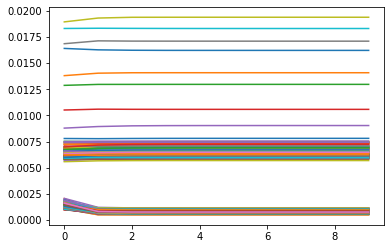

In [ ]:
real_value = X_test_for_conv[n].reshape(1,-1)
# Set time level n-m to n-1 as the input
real_value = real_value[:,:num_coeffs*(input_timestamps - 1)]
real_value = real_value.reshape((1, input_timestamps-1, X_test_for_conv.shape[2], 1))
# Set value of time level n as same as that of time level n-1
initial_pred = np.concatenate((real_value, real_value[:,-1:,:,:]), axis=1)
# Predict a point forward in time (time level n)
prediction_values,loss = predict_coding(initial_pred, real_value)
# Update real value and initial guess
X_predict = list(prediction_values.numpy().reshape(-1,num_coeffs))
# prediction of time level n
gen_predict = prediction_values[:,(input_timestamps - 1):,:,:]
# Add the predicted value to the real value
real_value = np.concatenate((real_value[:,1:,:,:], gen_predict), axis=1)
# Set value of time level n as same as that of time level n-1
initial_pred = np.concatenate((real_value, real_value[:,-1:,:,:]), axis=1)

# Predict prediction_num-1 points forward in time
for i in tqdm.tqdm(range(prediction_num-1)):
    prediction_values,loss = predict_coding(initial_pred, real_value)
    # Update input values and initial guess
    gen_predict = prediction_values[:,(input_timestamps - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_value = np.concatenate((real_value[:,1:,:,:], gen_predict), axis=1)
    initial_pred = np.concatenate((real_value, real_value[:,-1:,:,:]), axis=1)
X_predict = np.array(X_predict)

In [ ]:
print(X_predict.shape)

(720, 150)


## Process node results

In [ ]:
# Undo (0,1) scaling
X_inverse_01 = scaler_01.inverse_transform(X_predict)
# Undo PCA scaling
X_inverse_PCA = pca_compress.inverse_transform(X_inverse_01)
X_predict_split = np.hsplit(X_inverse_PCA, 7)

In [ ]:
# Undo (−1,1) scaling
pred_CO2 = scaler_CO2_test.inverse_transform(X_predict_split[0])
pred_Velocity_x = scaler_x_test.inverse_transform(X_predict_split[1])
pred_Velocity_y = scaler_y_test.inverse_transform(X_predict_split[2])
pred_Velocity_z = scaler_z_test.inverse_transform(X_predict_split[3])
pred_Humidity = scaler_Humidity_test.inverse_transform(X_predict_split[4])
pred_Temperature = scaler_Temperature_test.inverse_transform(X_predict_split[5])
pred_Virus1 = scaler_Virus1_test.inverse_transform(X_predict_split[6])

## Undo scaling for CFD data

In [ ]:
# Undo PCA scaling
X_CFD = pca_compress.inverse_transform(test_data)
X_CFD_split = np.hsplit(X_CFD, 7)

In [ ]:
# Undo (−1,1) scaling
CFD_CO2 = scaler_CO2_test.inverse_transform(X_CFD_split[0])
CFD_Velocity_x = scaler_x_test.inverse_transform(X_CFD_split[1])
CFD_Velocity_y = scaler_y_test.inverse_transform(X_CFD_split[2])
CFD_Velocity_z = scaler_z_test.inverse_transform(X_CFD_split[3])
CFD_Humidity = scaler_Humidity_test.inverse_transform(X_CFD_split[4])
CFD_Temperature = scaler_Temperature_test.inverse_transform(X_CFD_split[5])
CFD_Virus1 = scaler_Virus1_test.inverse_transform(X_CFD_split[6])

## Plot node results

In [ ]:
def plot_output(predict_data, CFD_data, filename):
  fig, ax = plt.subplots(3, 3, figsize=[16,10])
  fig.tight_layout(h_pad=3.5, w_pad=3.5)
  for i in range(9):
    ax.flatten()[i].plot(x_axis*5, predict_data[:real_timestamp+prediction_num,i*200], '-')
    ax.flatten()[i].plot(x_axis*5, CFD_data[n:n+(real_timestamp+prediction_num)*step:step,i*200], '-')
    ax.flatten()[i].plot(x_input*5, CFD_data[n:n+(real_timestamp)*step:step,i*200], 'd')
    ax.flatten()[i].legend(['Prediction', 'Fluidity', 'Input data'])
    ax.flatten()[i].set_title('Node '+ str(i*200+1))
    ax.flatten()[i].set_xlabel('Time (s)')
    ax.flatten()[i].set_ylabel(filename)
  path = '/content/drive/MyDrive/output_files/Figures/Figures_without_DA/Testing/'+str(filename)+'_prediction.png'
  plt.savefig(path)

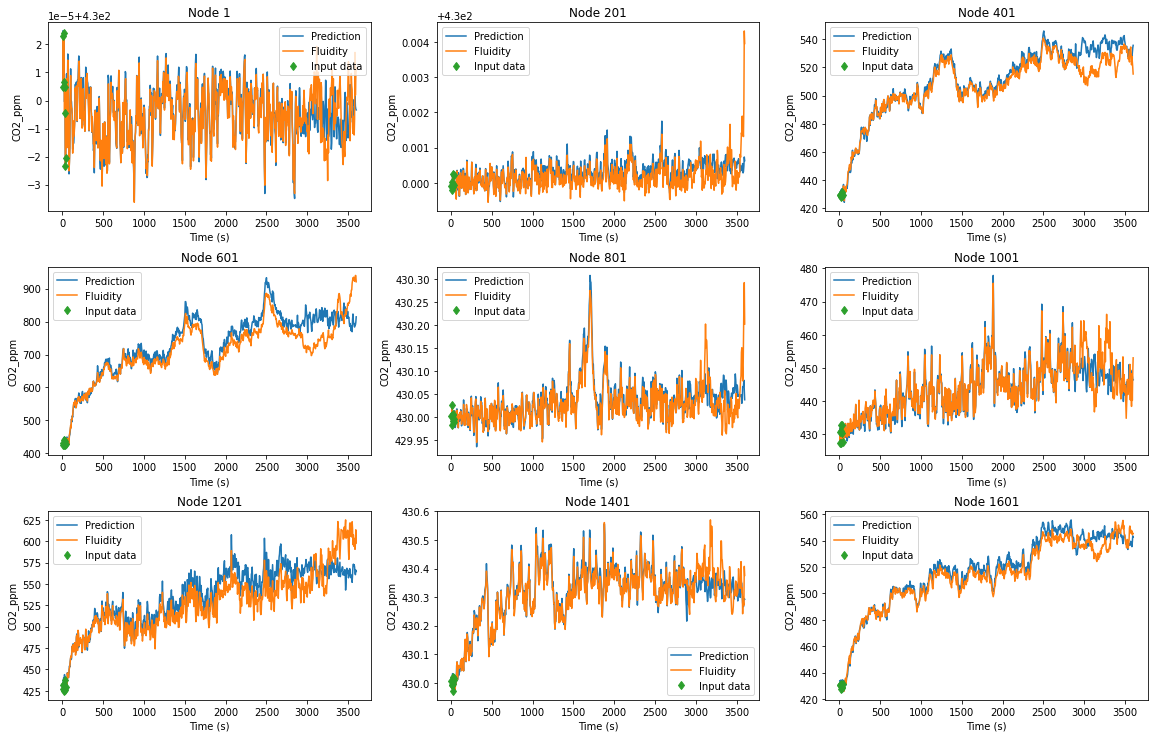

In [ ]:
plot_output(pred_CO2, CFD_CO2, 'CO2_ppm')

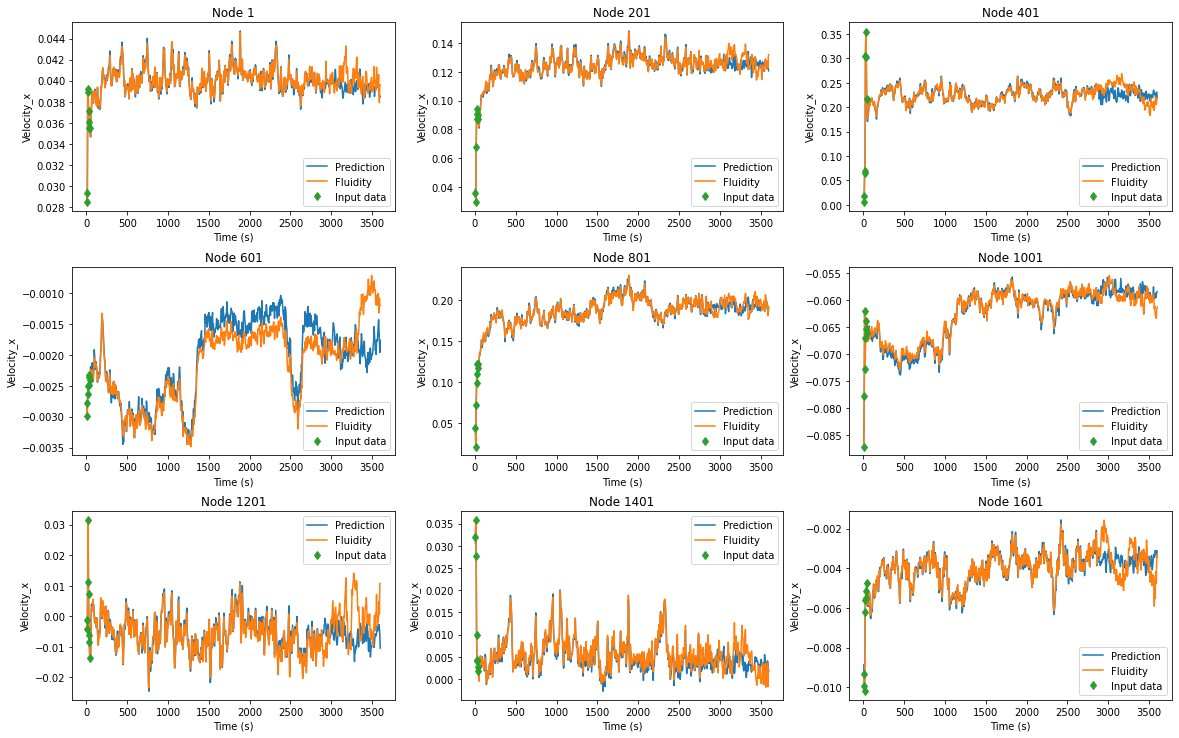

In [ ]:
plot_output(pred_Velocity_x, CFD_Velocity_x, 'Velocity_x')

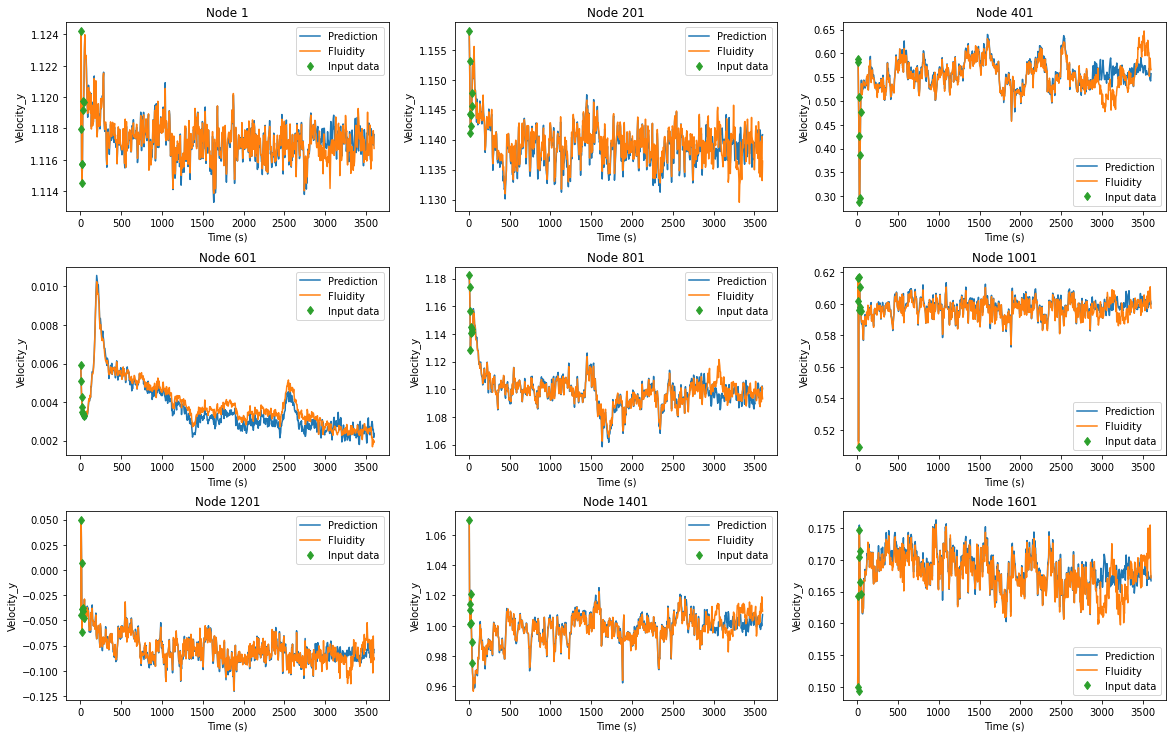

In [ ]:
plot_output(pred_Velocity_y, CFD_Velocity_y, 'Velocity_y')

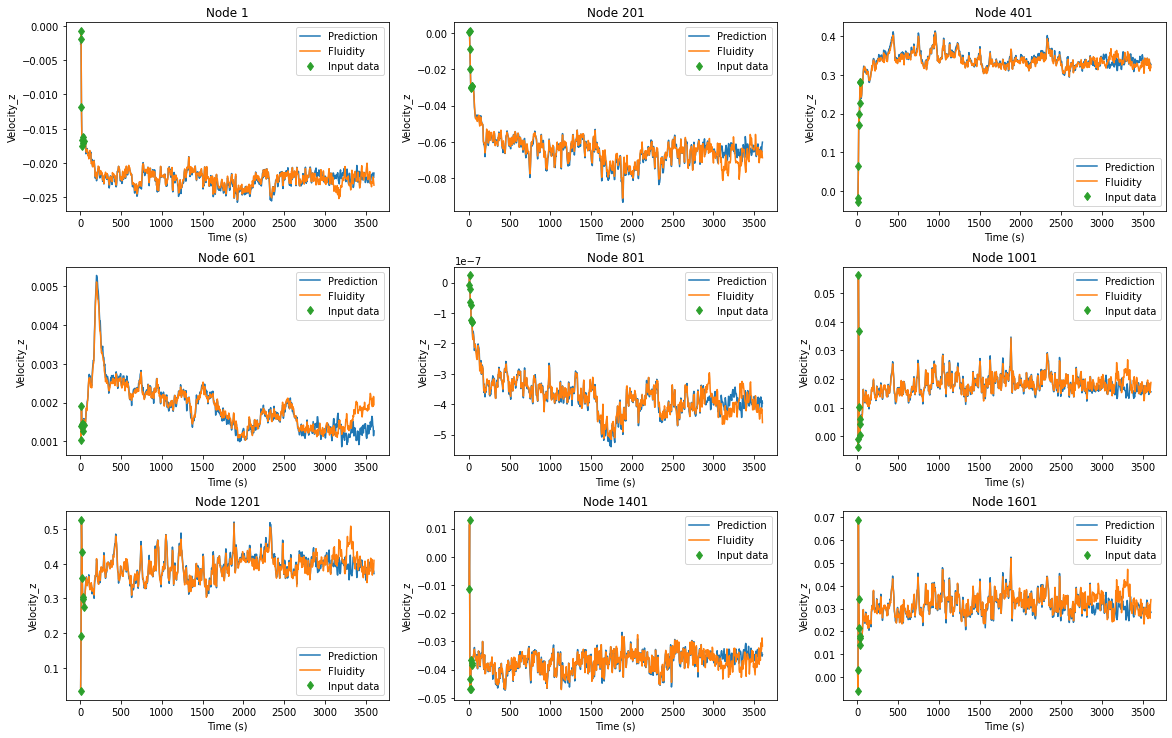

In [ ]:
plot_output(pred_Velocity_z, CFD_Velocity_z, 'Velocity_z')

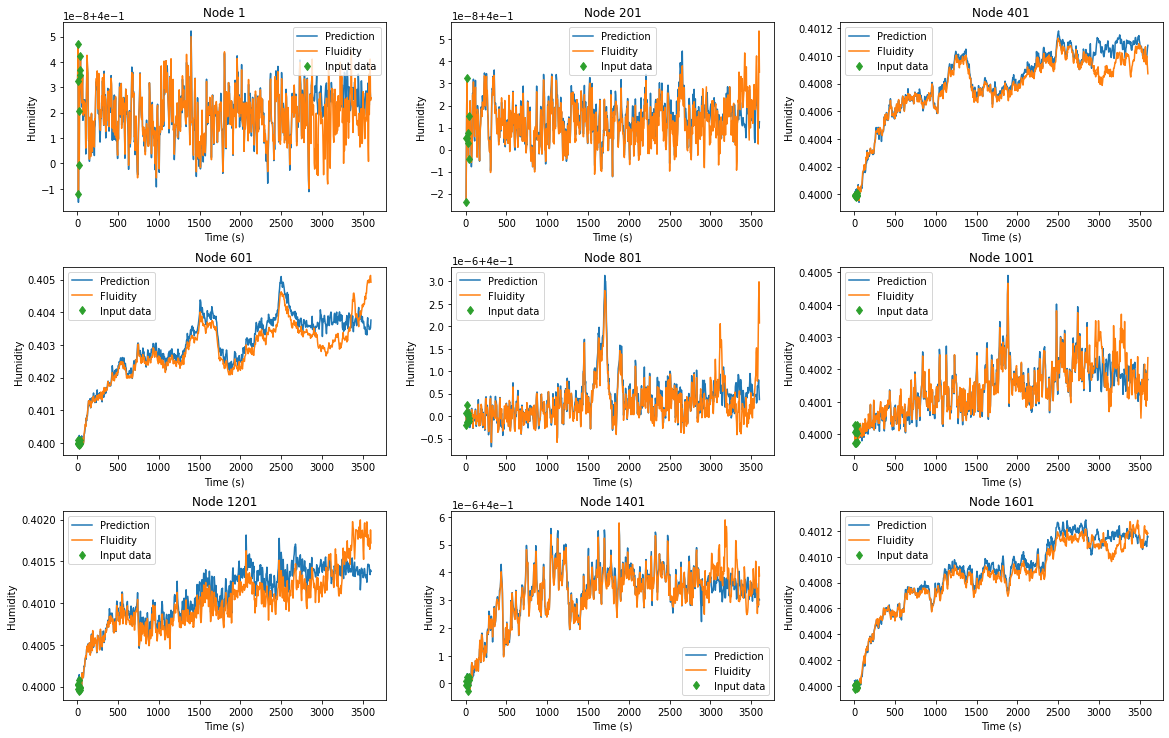

In [ ]:
plot_output(pred_Humidity, CFD_Humidity, 'Humidity')

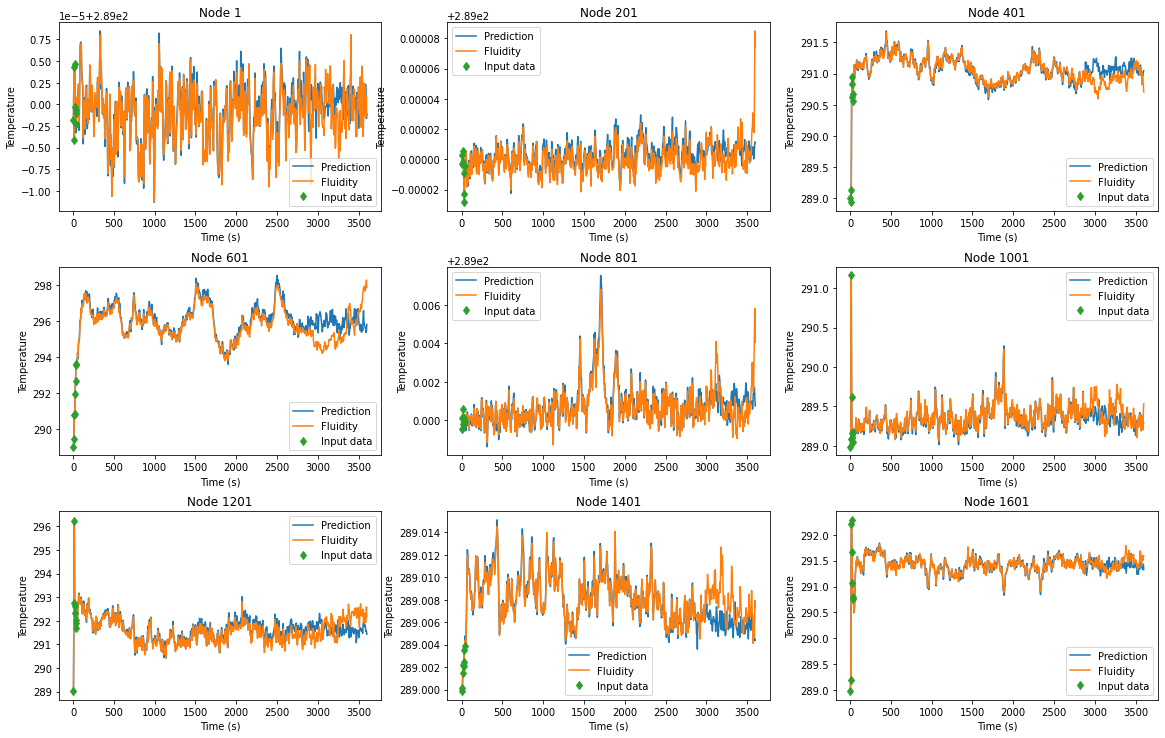

In [ ]:
plot_output(pred_Temperature, CFD_Temperature, 'Temperature')

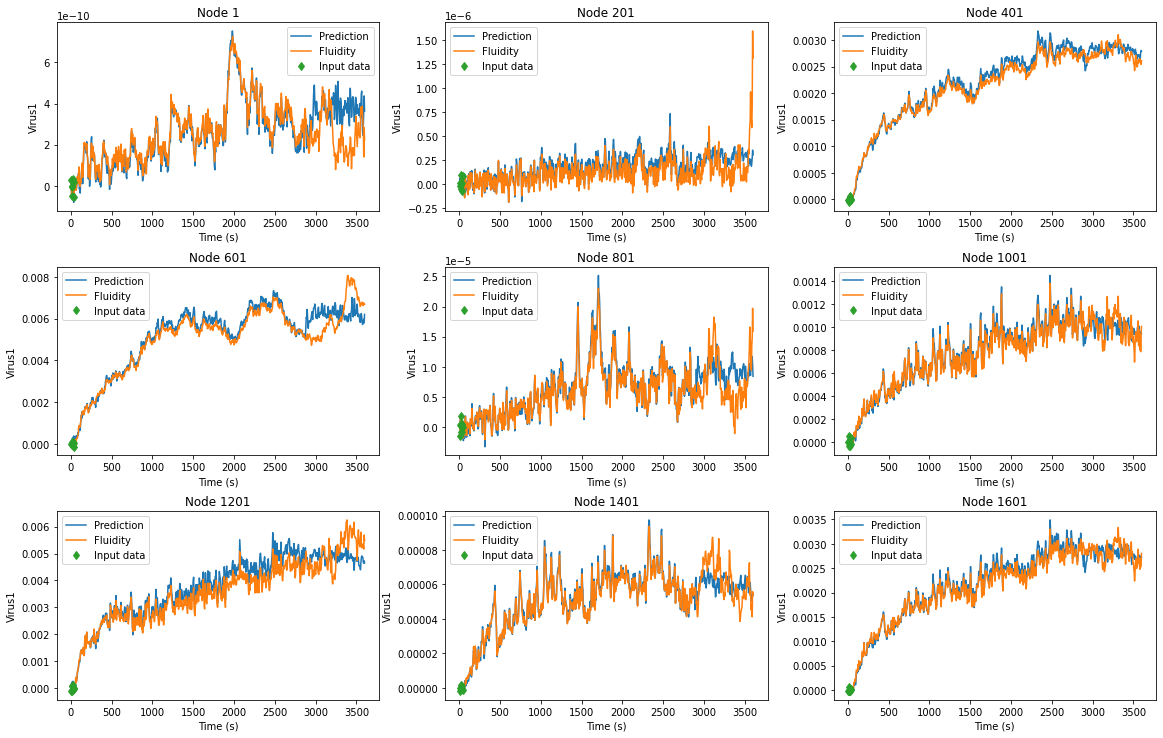

In [ ]:
plot_output(pred_Virus1, CFD_Virus1, 'Virus1')

## Write prediction results to .vtu files


In [ ]:
!pip -q install vtk

     |████████████████████████████████| 88.3 MB 102 kB/s 


In [ ]:
import os
os.chdir("/content/drive/MyDrive")
import vtktools
from tools_io import get_nNodes_from_vtu, get_clean_vtu_file

def write_example_to_vtu(i, exm_num, filepath):
  # get clean vtu file
  snapshot_data_location = '/content/drive/MyDrive/Cotrace_fixed_final/'
  snapshot_file_base = 'Cotrace_fixed_'
  filename = snapshot_data_location + snapshot_file_base + '582.vtu'
  clean_vtu = get_clean_vtu_file(filename)

  # write results to vtu
  nNodes = get_nNodes_from_vtu(snapshot_data_location, snapshot_file_base)
  CO2_ppm = np.zeros((nNodes,1))
  velocity = np.zeros((nNodes,3))
  humidity = np.zeros((nNodes,1))
  temperature = np.zeros((nNodes,1))
  virus1 = np.zeros((nNodes,1))

  new_vtu = vtktools.vtu()
  new_vtu.ugrid.DeepCopy(clean_vtu.ugrid)
  new_vtu.filename = filepath + str(exm_num) + '.vtu'

  CO2_ppm[:] = pred_CO2[i].reshape((192060, 1),order='F')
  velocity[:,0] = pred_Velocity_x[i].reshape((192060),order='F')
  velocity[:,1] = pred_Velocity_y[i].reshape((192060),order='F')
  velocity[:,2] = pred_Velocity_z[i].reshape((192060),order='F')
  humidity = pred_Humidity[i].reshape((192060, 1),order='F')
  temperature = pred_Temperature[i].reshape((192060, 1),order='F')
  virus1 = pred_Virus1[i].reshape((192060, 1),order='F')

  new_vtu.AddField('Tracer', CO2_ppm)
  new_vtu.AddField('Velocity', velocity)
  new_vtu.AddField('Humidity', humidity)
  new_vtu.AddField('Temperature', temperature)
  new_vtu.AddField('Virus1', virus1)
  new_vtu.Write()

In [ ]:
import tqdm
start = 1
end = real_timestamp + prediction_num
i = 0
for filenum in tqdm.tqdm(range(start,end+1,1)):
  path = 'output_files/vtu_files/vtu_without_DA/output_'
  write_example_to_vtu(i, filenum, path)
  i += 1

100%|██████████| 720/720 [59:28<00:00,  4.96s/it]


In [ ]:
import tqdm
start = 1
end = real_timestamp + prediction_num
i = 0
for filenum in tqdm.tqdm(range(start,end+1,6)):
  path = 'output_files/vtu_files/sparse_output/vtu_without_DA/output_'
  write_example_to_vtu(i, filenum, path)
  i += 6

100%|██████████| 120/120 [08:35<00:00,  4.30s/it]
